In [ ]:
import numpy as np
from copy import copy
import random

In [ ]:
def get_empty_2D_nparray(len):
    a = np.array([None] * len)
    for i in range(len):
        a[i] = []
    return a

In [ ]:
class HyperEdgeIterator:
    def __init__(self, position, np_lst):
        self.position = position
        self.np_lst = np_lst
    
    def __iter__(self):
        return self

    def __next__(self):
        self.position += 1
        if self.position >= self.np_lst.shape[0]:
            raise StopIteration
        return self.np_lst[self.position]

class HyperEdge:
    def __init__(self, vertexes=[], weight=1, num=None):
        # assert len(vertexes) > 1 # restricted edges wigh size <= 1
        self.vertexes = np.sort(np.array(vertexes))
        self.weight = weight
        self.num = num

    def get_vertexes(self):
        return self.vertexes

    def add_weight(self, delta):
        self.weight += delta
    
    def __len__(self):
        return len(self.vertexes)

    def __eq__(self, other):
        return (self.vertexes == other.vertexes).all()

    def __hash__(self):
        return hash(tuple(self.vertexes))

    def __iter__(self):
        return HyperEdgeIterator(-1, self.vertexes)

    def __str__(self):
        return "Edge#" + str(self.num) + " = " + str(self.vertexes)[:-1] + "| w = " + str(self.weight) + "]"

class Hypergraph:
    def __init__(self, number_of_vertexes):
        self.hyperedges = []
        self.number_of_vertexes = number_of_vertexes
        self.adjlist = get_empty_2D_nparray(number_of_vertexes)
        self.hyperedge_number = dict()

    def add_hyperedge(self, list_of_verticles, weight=1):
        edge_num = len(self.hyperedges)
        new_edge = HyperEdge(vertexes=list_of_verticles, weight=weight)

        if new_edge in self.hyperedge_number.keys():
            edge_num = self.hyperedge_number[new_edge]
            self.hyperedges[edge_num].add_weight(weight)
        else:
            self.hyperedge_number[new_edge] = edge_num
            new_edge.num = edge_num
            self.hyperedges.append(new_edge)
            # adding edge_num to adjancted vertexes
            for vertex in new_edge:
                self.adjlist[vertex].append(edge_num)
    
    def n_vertex(self):
        return self.number_of_vertexes

    def print(self):
        for i, edge in enumerate(self.hyperedges):
            print('Edge# ' + str(i) + " = [", end = "")
            print(edge.vertexes[0], end = "")
            for v in edge.vertexes[1:]:
                print(", ", v, end = "", sep = "")
            print("| w = ", edge.weight, "]", sep="")
G = Hypergraph(5)
G.add_hyperedge([1, 2, 4], 1)
G.add_hyperedge([1, 2, 3], 2)
G.add_hyperedge([3, 4], 3)
G.print()

Edge# 0 = [1, 2, 4| w = 1]
Edge# 1 = [1, 2, 3| w = 2]
Edge# 2 = [3, 4| w = 3]


Функция φ(z) = p, где p - partition, z - номера кластеров вершин \\
φ - просто считает для каждого класса количество его встречаемостей в z. \\
Далее эти количества сортируются по убыванию и выкидываются = 0.

In [ ]:
def φ(z):
    z = np.array(z)
    z = np.sort(z)
    assert(z.shape[0] != 0)
    ans = [0]
    prev_label = z[0]
    for label in z:
        if prev_label == label:
            ans[-1] += 1
            continue
        else:
            ans.append(1)
            prev_label = label
    return sorted(ans, key = lambda x: -x)
assert φ([1, 1, 2, 3, 3, 5]) == [2, 2, 1, 1]
assert φ([2, 2, 2, 2]) == [4]
assert φ([1,1,4,1,2,3,2]) == [3,2,1,1]

Функция $z_R(z, R)$: \\
z - номера кластеров вершин \\
R - гиперребро \\
$z_R$ считает вектор z, ограниченный на вершины гиперребра.

In [ ]:
def z_R(z, R: HyperEdge):
    '''
        Номера не сохраняются!!!
        Только набор
    '''
    # r - hyperedge
    # z - labels
    distinkt_vertexes = np.unique(R.vertexes)
    ans = np.zeros(distinkt_vertexes.shape[0], dtype=int)
    id = 0
    for vertex in distinkt_vertexes:
        ans[id] = z[vertex]
        id += 1
    return list(ans)

e1 = HyperEdge([1, 3, 2, 2], 4, 0)
e2 = HyperEdge([3, 3, 3], 4, 0)
e3 = HyperEdge([1, 2, 0], 5, 0)
assert z_R([1, 2, 3, 4, 5], e1) == [2, 3, 4]
assert z_R([1, 2, 3, 4, 5], e2) == [4]
assert z_R([1, 1, 1, 2, 2], e3) == [1, 1, 1]
assert φ(z_R([1, 1, 1, 2, 2], e3)) == [3]

$get\_d(H)$:
считает вектор d для гиперграфа H. \\
d[i] = сумма весов ребер, покрывающих вершину i. \\
(c 5, (9) в статье)

In [ ]:
def get_d(H: Hypergraph):
    '''
    d[vertex] - cуммарный вес ребер, накрывающий вершину vertex
    ! Если в гиперребре 2 раза встречается вершина, кто ее весовой коэффициент - x2!!! правильно ли это???
    '''
    d = np.zeros((H.number_of_vertexes), dtype=int)
    for edge in H.hyperedges:
        for vertex in edge:
            d[vertex] += edge.weight
    return list(d)
assert get_d(G) == [0, 3, 3, 5, 4]

$cut(H, p, z)$:
принимает H - гиперграф, p - фиксированный вектор partition(разбиения), z - номера кластеров вершин

Возвращает: сумму весов гиперребер, partition которых = p (учитывая, что метки классов = z) \\
Фомула из статьи (с 6, (12)): \\
$$cut_p(z) = \sum_{R\in R^k}a_Rδ(p, ϕ(z_R))$$ \\
$R^k$ - подмножество ребер состоящих из k вершин.
В моей реализации я пробегаюсь по всем ребрам, но функция все равно - правильная, так как ребра не того размера автоматически отсекуться условием в 9 строчке (так как сумма элементов в p = количество вершин гиперребра)

In [ ]:
def cut(H: Hypergraph, p, z):
    # p = φ(z) - partition vector
    # z - labels
    p = list(p)
    k = sum(p)
    ans = 0

    for hyper_e in H.hyperedges:
        if p == φ(z_R(z, hyper_e)):
            ans += hyper_e.weight
    return ans
assert cut(G, [2, 1], [1, 2, 2, 3, 3]) == 3

$vol\_single(H, label, z, d):$ (в статье c 5, чуть ниже (9)) \\
H - гиперграф \\
label - зафиксированный номер кластера \\
z - номера кластеров вершин \\
d: d[i] - сумма весов ребер, покрывающих вершину i. (= get_d(H)) \\
Возвращает:
$vol(label) = \sum_{i=1}^{n} d_iδ(z_i, label)$ \\

In [ ]:
def vol_single(H: Hypergraph, label, z, d = None):
    '''
        label - метка вершины
        z - вектор, текущая кластеризация
        d - вектор, d[vertex] - сумма весов гиперребер, которые накрывают данную вершину
    '''
    ans = 0
    if d == None:
        d = get_d(H)

    for vertex in range(H.number_of_vertexes):
        if z[vertex] == label:
            ans += d[vertex]
    return ans
assert vol_single(G, 3, [1, 2, 2, 3, 3]) == 9
assert vol_single(G, 1, [1, 2, 2, 3, 3]) == 0
assert vol_single(G, 2, [1, 2, 2, 3, 3]) == 6
assert vol_single(G, 4, [1, 2, 2, 3, 3]) == 0

$power\_of\_ordered\_set\_sequence(A, k):$
вспомогательная функция, генерирует все подпоследовательности длины k множества А \\
может быть попробована как альтернатива следующей функции в вычислении vol

In [ ]:
def power_of_ordered_set_sequence(A, k):
    assert k != 0
    A = list(np.unique(A))

    n = len(A) if type(A) == list else A.shape[0]

    sett = [A[0]] * k
    id_sett = [0] * k
    cnt = n ** k
    while cnt > 0:
        yield sett
        cnt -= 1
        if cnt == 0:
            break
        
        # Найти следующую последовательность
        for i in range(k - 1, -1, -1):
            if sett[i] == A[-1]:
                continue
            sett[i] = A[id_sett[i] + 1]
            for j in range(i + 1, k):
                sett[j] = A[0]
                id_sett[j] = 0
            id_sett[i] += 1
            break
for x in power_of_ordered_set_sequence(['a', 'b', 'c'], 2):
    print(x)

['a', 'a']
['a', 'b']
['a', 'c']
['b', 'a']
['b', 'b']
['b', 'c']
['c', 'a']
['c', 'b']
['c', 'c']


$power\_of\_unordered\_set\_sequence(A, k):$
вспомогательная функция, генерирует все k-элементные подмножества множества А в лексикографическом порядке.

In [ ]:
def start_generate(A, k, possible_id, lst = ()): # id - cейчас индекс
    lst = list(lst)
    if len(lst) == k:
        yield copy(lst)
        return
    
    for id1 in range(possible_id, len(A)):
        lst.append(A[id1])
        for l1 in start_generate(A, k, id1, lst):
            yield copy(l1)
        lst.pop()
    return

def power_of_unordered_set_sequence(A, k):
    assert k != 0
    lst = []
    A = list(np.unique(A))
    n = len(A) if type(A) == list else A.shape[0]
    gen = start_generate(A, k, 0, [])
    return gen
for x in power_of_unordered_set_sequence([1, 2, 3], 2):
    print(x)

[1, 1]
[1, 2]
[1, 3]
[2, 2]
[2, 3]
[3, 3]


$vol(H, p, z):$ (в статье с 6, (13)):
$$vol_p(z) = \sum_{y \in [1, ..., l]^k}δ(p, ϕ(y))\prod\limits_{y \in y}vol(y)$$ \\
сумма берется по всем векторам y, порождающим разбиение p. \\
Я перебираю эти вектора по всем подмножеством [1, ..., l] размера k. ТАким образом, что порядок следования классов в y неважен. Т.е. из векторов [1, 1, 2, 2] и [1, 2, 1, 2] ... [2, 2, 1, 1] (все векторы с двумя 1 и двумя 2) в суммировании будет рассмотрен лишь 1. \\

Из статьи я не понял, так надо суммировать или как-то по-другому.

In [ ]:
def vol(H: Hypergraph, p, z):
    '''
        p - partition vector, убывающий
        z - вектор, текущая кластеризация.

        а y должен быть множеством, мультимножеством? И как упорядочен?
        из конца 4 - начала 5 страницы следует, что y - неупорядоченное подмножество z^k Прав ли я?
    '''
    assert min(z) == 1
    p = list(p)
    z = list(z)

    for i in range(1, len(p)):
        assert(p[i - 1] >= p[i])

    ans = 0
    k = sum(p)
    l = max(z) # unique(z) = [1, ... maxz]

    d = get_d(H)

    # здесь либо порядок в y - важен, либо нет. Я это не до конца из статьи понял
    # то есть либо power_of_ordered_set_sequence, либо power_of_unordered_set_sequence.
    # обе дают неправильный результат
    for y in power_of_ordered_set_sequence(z, k):
        if p == φ(y):
            prod = 1
            y_unique = np.unique(y)
            for y1 in y_unique: # здесь произведение по всем y, или только по различным???
                prod *= vol_single(H, y1, z, d)
            ans += prod
    return ans
vol(G, [2, 1], [1, 2, 2, 3, 3]) # 108

324

$vol\_of\_graph(H):$ (в статье с 8, (верхняя часть)):
$vol(H) = \sum_{i=1}^n {d_i}$;   \\
$d_i$,  - сумма весов 
ребер, накрывающих вершину i \\


In [ ]:
def vol_of_graph(H: Hypergraph):
    sum = 0
    for edge in H.hyperedges:
        sum += edge.weight * len(edge)
    return sum

$m_k(H, k): $ (в статье с 7, (16))
сумма весов гиперребер, костоящих из k вершин \\

$$m_k = \sum_{R \in R^k}a_R$$ \\


In [ ]:
def m_k(H: Hypergraph, k):
    sum = 0
    for edge in H.hyperedges:
        H.hyperedges
        if len(edge) == k:
            sum += edge.weight
    return sum
assert vol_of_graph(G) == 15
assert m_k(G, 1) == 0
assert m_k(G, 2) == 3
assert m_k(G, 2) == 3

$All\_or\_Nothing(p)$ (с 8) - принимает вектор-partition p, и в зависимости от того, 1 !!!(если все равны или нет) в нем элемент или несколько возвращает значение. \\

Это - strict modularity, такое, что:
$w_{k0}$ и $w_{k1}$ такие, что $β_k = 1$ и $γ_k = \frac{m_k}{(vol(H))^k} $

Так как далее в функции Q будет браться логарифм от $All\_or\_Nothing$, то в случае 0 возвращаемого значения, возврящяется $10^{-10}$

In [ ]:
def All_or_Nothing(H: Hypergraph, p):
    # wk0, wk1 
    p = list(p)
    k = sum(p)

    wk0 = m_k(H, k) / (vol_of_graph(H) ** k)
    if wk0 == 0:
        wk0 = 10 ** -10
    wk1 = wk0 * 2
    
    if np.unique(p).shape[0] == 1:
        return wk1
    else:
        return wk0

$generate\_decrease\_partitions(final\_sum, current\_sum, lst = []):$ \\
вспомогательная функция, которая генерирует все невозрастающие векторы-partition с суммой элементов = final_sum \\
current_sum, lst - служебные поля.

In [ ]:
def generate_decrease_partitions(final_sum, current_sum, lst = ()):
    lst = list(lst)
    '''
        генерирует все невозрастающие векторы-partition с суммой элементов = sum;
        все элементы >= 1
    '''
    if final_sum == current_sum:
        yield copy(lst)
    
    if current_sum >= final_sum:
        return

    prev_elem = 10**10 if len(lst) == 0 else lst[-1]

    R = min(prev_elem, final_sum - current_sum)

    for x in range(R, 0, -1):
        lst.append(x)
        for l1 in generate_decrease_partitions(final_sum, current_sum + x, lst):
            yield copy(l1)
        lst.pop()
    return
for x in generate_decrease_partitions(4, 0):
    print(x)

[4]
[3, 1]
[2, 2]
[2, 1, 1]
[1, 1, 1, 1]


Функция $cut_k(H, z, k):$ (с 7, (16)) - специализированная функция, нужная для того, чтобя посчитать функцию модулярности (Q) для случая $Ω = All\_Or\_Nothing$
H - гиперграф \\
z - кластеризация \\
k - размер гиперребра
$cut_k(z) = m_k - \sum_{R \in R_k}{a_Rδ(z_R)}$ \\
где $δ(z_R) = 1,$ если данное гиперребро лежит в 1 кластере целиком

In [ ]:
def cut_k(H: Hypergraph, z, k):
    ans = m_k(H, k)
    for edge in H.hyperedges:
        if len(edge) == k and len(φ(z_R(z, edge))) == 1:
            ans -= edge.weight
    return ans

Функция $Q\_for\_all\_or\_nothing(H, z, Ω, d): (с7, (15))$ Специализированная под  $All\_Or\_Nothing$ функцию модулярности.
$$Q(z, Ω, d) = -\sum_{i=1}^{k}[cut_i(z) + γ_i\sum_{l=1}^{L}vol(l)^i]$$, где 
$β_k = log(w_{k1}) - log(w_{k0}), γ_k = β_k^{-1}(w_{k1} - w_{k0}).$ \\
Из strick modularity:
$β_k = 1$ и $γ_k = \frac{m_k}{(vol(H))^k} $

In [ ]:
def Q_for_all_ar_nothing(H: Hypergraph, z, Ω, d):
    unique_labels = list(np.unique(z))

    # β = np.log(w_k1) - np.log(w_k0)
    # γ = (w_k1 - w_k0) / β
    β = 1

    ans = 0.0

    k = 0 # k - vаксимальный размер гиперребра гиперграфа H
    for edge in H.hyperedges:
        k = max(k, edge.vertexes.shape[0])

    for i in range(1, k + 1):
        γ = m_k(H, i) / (vol_of_graph(H) ** i)
        sum_vol = 0
        for label in unique_labels:
            sum_vol += (vol_single(H, label, z) ** i)
        ans -= β * (cut_k(H, z, i) + γ * sum_vol)
    return ans
Q_for_all_ar_nothing(G, [1, 2, 2, 3, 3], All_or_Nothing, get_d(G))

-5.4

функция $Q(H, z, Ω, d):$ (с 6, (14))
Насколько я понял это - обобщение функции модулярности для гиперграфа. \\
Ω - это (например) $All\_or\_Nothing$
$$Q(\textbf{z}, \Omega, d) = \sum_{p\in \textit{P}} [cut_p(z)\logΩ(p) - vol_p(z)Ω(p)]$$ \\
Где сумма берется по всем векторам - partition p, в которых сумма элементов (т.е. количество вершин) <= максимального размера гиперребра в графе.

# Именно с ней какая-то проблема: все еще получаются неправильные разбиения.

In [ ]:
def Q(H: Hypergraph, z, Ω, d):
    '''
        z - вектор, кекущая кластеризация
        Ω - функция (affinity function), Например, All-Or-Nothing
        d - вектор, d[i] - сумма весов гиперребер, покрывающих вершину i
    '''

    k = 0 # k - vаксимальный размер гиперребра гиперграфа H
    for edge in H.hyperedges:
        k = max(k, edge.vertexes.shape[0])

    ans = 0.0

    for partition_sum in range(1, k + 1):
        for p in generate_decrease_partitions(partition_sum, 0):
            Omega = Ω(H, p)
            ans += cut(H, p, z) * np.log(Omega) - vol(H, p, z) * Omega
    return ans
print(Q(G, [1, 2, 2, 3, 3], All_or_Nothing, get_d(G)))

-35.54430441251132


### Тест на гиперграфах, состоящих из 2 клик, связанных между собой 1 ребром.

In [ ]:
'''
2 клики (0, 1, 2) - (3, 4, 5);
вектор идеального разбиения = [1, 1, 1, 2, 2, 2]
'''
G1 = Hypergraph(6)
for i in range(3):
    for j in range(i + 1, 3):
        G1.add_hyperedge([i, j], 1)

for i in range(3, 6):
    for j in range(i + 1, 6):
        G1.add_hyperedge([i, j], 1)

G1.add_hyperedge([2, 3], 1)
G1.print()

Edge# 0 = [0, 1| w = 1]
Edge# 1 = [0, 2| w = 1]
Edge# 2 = [1, 2| w = 1]
Edge# 3 = [3, 4| w = 1]
Edge# 4 = [3, 5| w = 1]
Edge# 5 = [4, 5| w = 1]
Edge# 6 = [2, 3| w = 1]


В тесте, почему-то показывает, что наибольшее значение Q, когда все вершины в разных кластерая. Я не понимаю, почему так.

In [ ]:
print("Q = ", Q(G1, [1, 1, 1, 1, 1, 1], All_or_Nothing, get_d(G1)))
print("Q = ", Q(G1, [1, 1, 1, 2, 2, 2], All_or_Nothing, get_d(G1)))
print("Q = ", Q(G1, [1, 2, 3, 4, 5, 6], All_or_Nothing, get_d(G1)))

Q =  -19.473401310106812
Q =  -26.473401310106812
Q =  -31.044829881535385


А вот новая функция Q_for_all_ar_nothing работает хорошо

In [ ]:
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G1, [1, 1, 1, 1, 1, 1], All_or_Nothing, get_d(G1)))
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G1, [1, 1, 1, 2, 2, 2], All_or_Nothing, get_d(G1)))
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G1, [1, 2, 3, 4, 5, 6], All_or_Nothing, get_d(G1)))

Q_for_all_ar_nothing =  -7.0
Q_for_all_ar_nothing =  -4.5
Q_for_all_ar_nothing =  -8.214285714285714


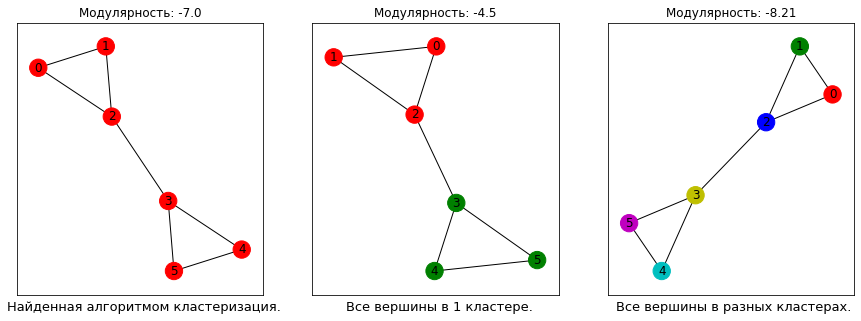

In [ ]:
visualize(G1, [[1, 1, 1, 1, 1, 1], [1, 1, 1, 2, 2, 2], [1, 2, 3, 4, 5, 6]])

In [ ]:
def get_n_clique_G(n, k, t):
    '''
    n - количество клик
    k - их размер
    t - количество рандомных ребер
    '''
    G = Hypergraph(n * k)
    A = get_empty_2D_nparray(n)
    for v in range(n * k):
        A[v // k].append(v)
    for cl in range(n):
        for i1 in range(0, k):
            for i2 in range(i1 + 1, k):
                v1 = A[cl][i1]
                v2 = A[cl][i2]
                G.add_hyperedge([v1, v2], 1)
    for _ in range(t):
        L = list(range(n))
        cl1 = np.random.choice(L)
        L.remove(cl1)
        cl2 = np.random.choice(L)
        v1 = np.random.randint(0, k) + cl1 * k
        v2 = np.random.randint(0, k) + cl2 * k
        G.add_hyperedge([v1, v2])
    return G

In [ ]:
def get_rangom_clusterization(n, num_clusters):
    return list(np.random.randint(1, num_clusters + 1, n))

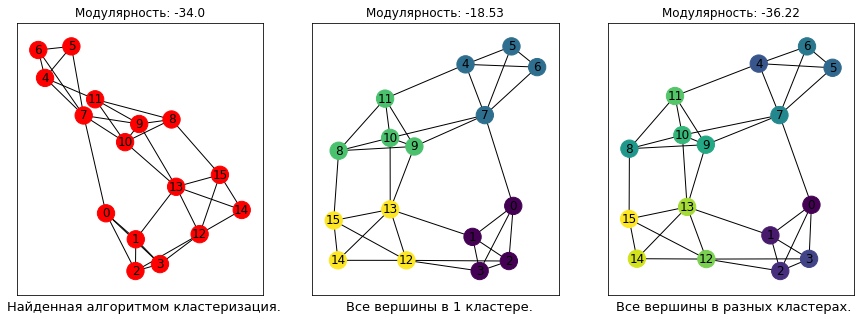

In [ ]:
GG = get_n_clique_G(4, 4, 10)
n = 16
GG_z0 = [1] * n
GG_z1 = SymmetricHMLL(GG, Q_for_all_ar_nothing, All_or_Nothing)
GG_z2 = list(range(n))
visualize(GG, [GG_z0, GG_z1, GG_z2])

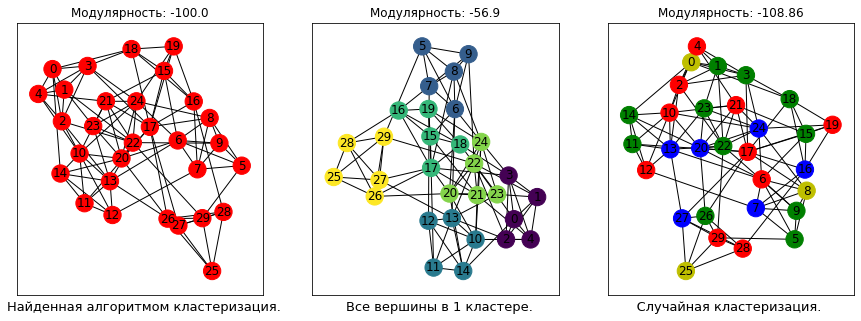

In [ ]:
GG = get_n_clique_G(6, 5, 40)
n = GG.number_of_vertexes
GG_z0 = [1] * n
GG_z1 = SymmetricHMLL(GG, Q_for_all_ar_nothing, All_or_Nothing)
GG_z2 = get_rangom_clusterization(n, 4)
visualize(GG, [GG_z0, GG_z1, GG_z2])

In [ ]:
GG_z0 = [1] * n

In [ ]:
GG_z1 = SymmetricHMLL(GG, Q_for_all_ar_nothing, All_or_Nothing)
GG_z2 = list(range(n))

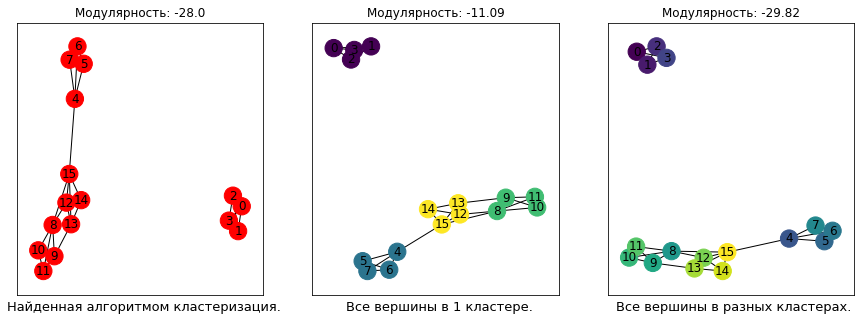

In [ ]:
visualize(GG, [GG_z0, GG_z1, GG_z2])

In [ ]:
G3 = Hypergraph(20)
for i in range(10):
    for j in range(i + 1, 10):
        G3.add_hyperedge([i, j], 1)

for i in range(10, 20):
    for j in range(i + 1, 20):
        G2.add_hyperedge([i, j], 1)

G2.add_hyperedge([9, 10], 1)

# векторы разбиения. z2 - самый лучший (должен быть)
z1 = [1] * 20
z2 = [1] * 10 + [2] * 10
z3 = list(range(1, 21))
print(z1, z2, z3, sep = "\n")

Следующий тест - 2 клики на 10 вершинах.

In [ ]:
G2 = Hypergraph(20)
for i in range(10):
    for j in range(i + 1, 10):
        G2.add_hyperedge([i, j], 1)

for i in range(10, 20):
    for j in range(i + 1, 20):
        G2.add_hyperedge([i, j], 1)

G2.add_hyperedge([9, 10], 1)

# векторы разбиения. z2 - самый лучший (должен быть)
z1 = [1] * 20
z2 = [1] * 10 + [2] * 10
z3 = list(range(1, 21))
print(z1, z2, z3, sep = "\n")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
    fig = plt.figure(1, figsize=(10, 10))
    nx.draw(G2, with_labels=True)

    fig = plt.figure(2, figsize=(10, 10))
    nx.draw(G2, node_color=color_map, with_labels=True)
plt.savefig('test_networks.pdf', format='pdf')

In [ ]:
plt.savefig('test_networks.pdf', format='pdf')
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
nx.draw_networkx(get_graph(G2), ax=ax[0], node_color=colors[z1])
nx.draw_networkx(get_graph(G2), ax=ax[1], node_color=colors[z2])
nx.draw_networkx(get_graph(G2), ax=ax[2], node_color=z3)
ax[0].set_title("Модулярность: ")
ax[1].set_title("Модулярность: ")
ax[2].set_title("Модулярность: ")

plt.show()

In [ ]:
colors = np.array(['r', 'r', 'g', 'b', 'y', 'c', 'm'])


In [ ]:
def get_graph(G):
    G2 = nx.Graph()
    for i in G.hyperedges:
        u = i.vertexes[0]
        v = i.vertexes[1]
        G2.add_edge(u, v)
    return G2

In [ ]:
def visualize_clusterisation(G: Hypergraph, z):
    colors = np.array(['r', 'r', 'g', 'b', 'y', 'c', 'm'])
    color_map = z
    G2 = nx.Graph()
    for i in G.hyperedges:
        u = i.vertexes[0]
        v = i.vertexes[1]
        G2.add_edge(u, v)

    q = Q_for_all_ar_nothing(G, z, All_or_Nothing, get_d(G))

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.suptitle('Модулярность: ' + str(q))
    # nx.draw_networkx(G2, ax=ax[0], node_color='b')
    if np.unique(z).shape[0] > len(colors):
        nx.draw_networkx(G2, ax=ax, node_color=z, lay)
    else:
        nx.draw_networkx(G2, ax=ax, node_color=colors[z])
    plt.show()

In [ ]:
def get_colors(x):
    x = list(x)
    if max(x) >= colors.shape[0]:
        return x
    return colors[x]

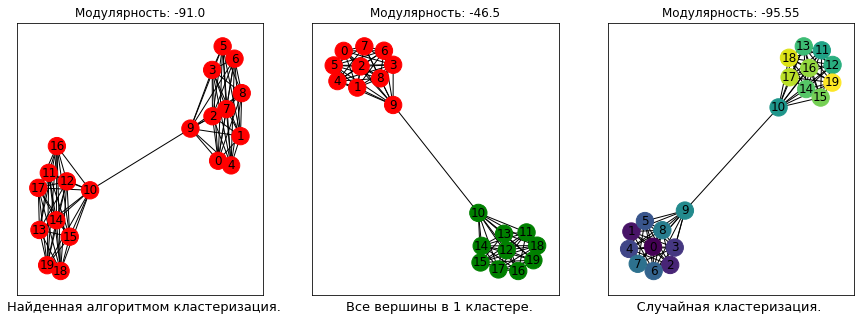

In [ ]:
def visualize(G: Hypergraph, A): # A = [z1, z2, ...]
    G2 = get_graph(G)

    d = get_d(G)
    fig, ax = plt.subplots(1, len(A), figsize = (len(A) * 5, 5))

    #ax[0].figtext("234241q3")
    
    plt.figtext(0.116, 0.08, "Найденная алгоритмом кластеризация.", size=13)
    plt.figtext(0.43, 0.08, "Все вершины в 1 кластере.", size=13)
    plt.figtext(0.68, 0.08, "     Случайная кластеризация.", size=13)
    for i in range(len(A)):
        # nx.draw_networkx(G2, ax=ax[i], node_color=get_colors(A[i]))
        nx.draw_networkx(G2, ax=ax[i], node_color=get_colors(A[i]))
        q = Q_for_all_ar_nothing(G, A[i], All_or_Nothing, d)
        ax[i].set_title("Модулярность: " + str(round(q, 2)))
    plt.savefig('test_networks.jpg', format='jpg')
    plt.show()
visualize(G2, [z1, z2, z3])

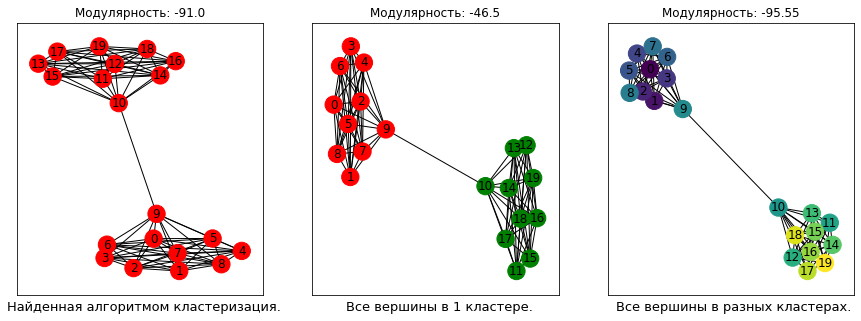

In [ ]:
visualize(G2, [z1, z2, z3])

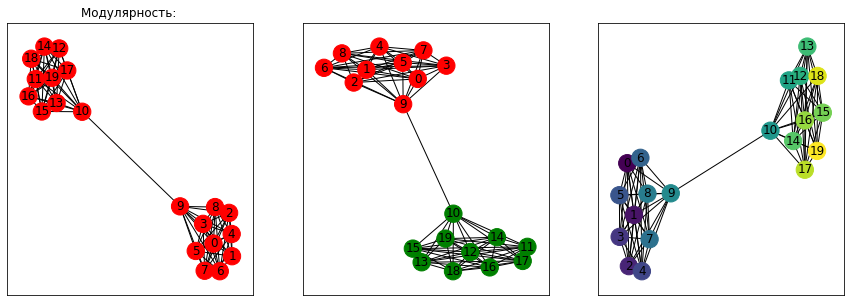

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
nx.draw_networkx(get_graph(G2), ax=ax[0], node_color=colors[z1])
nx.draw_networkx(get_graph(G2), ax=ax[1], node_color=colors[z2])
nx.draw_networkx(get_graph(G2), ax=ax[2], node_color=z3)
ax[0].set_title("Модулярность: ")
ax[1].set_title("Модулярность: ")
ax[2].set_title("Модулярность: ")

plt.show()

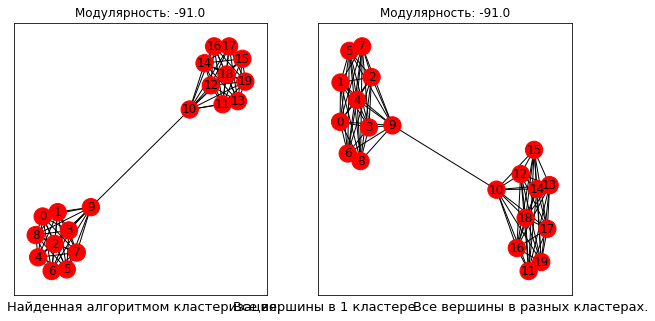

In [ ]:
visualize(G2, [z1, z1])

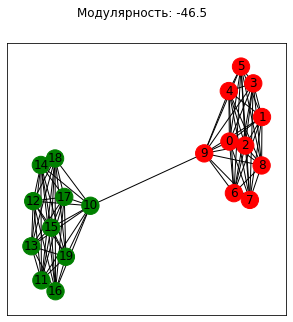

In [ ]:
visualize_clusterisation(G2, z2)

Тоже получается, что идеальное разбиение - когда все в 1 кластере. Непонятно почему.

In [ ]:
print("Q = ", Q(G2, z1, All_or_Nothing, get_d(G2)))
print("Q = ", Q(G2, z2, All_or_Nothing, get_d(G2))) # это должно быть наибольшим, но нет!
print("Q = ", Q(G2, z3, All_or_Nothing, get_d(G2)))

А вот новая функция Q_for_all_ar_nothing работает хорошо

In [ ]:
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G2, z1, All_or_Nothing, get_d(G2)))
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G2, z2, All_or_Nothing, get_d(G2))) # это должно быть наибольшим, но нет!
print("Q_for_all_ar_nothing = ", Q_for_all_ar_nothing(G2, z3, All_or_Nothing, get_d(G2)))

Q_for_all_ar_nothing =  -91.0
Q_for_all_ar_nothing =  -46.5
Q_for_all_ar_nothing =  -95.55494505494505


Функция $get\_nodes\_with\_cluster(H, z, c):$ Вспомогательная функция, возвращает список вершин в данном кластере c, соответствующий кластеризации z

In [ ]:
def get_nodes_with_cluster(H: Hypergraph, z, c):
    ans = []
    for vertex in range(H.number_of_vertexes):
        if z[vertex] == c:
            ans.append(vertex)
    return ans

Функция $get\_adjancted\_clusters(H, z, Sc):$ Вспомогательная функция, находит все кластеры, смежные с вершинами Sc (все вершины Sc находятся в 1 кластере). Потом мы попробуем объединить кластер Sc с новым кластером

In [ ]:
def get_adjancted_clusters(H: Hypergraph, z, Sc):
    '''
        Sc - множество, к которому нужно найти смежные кластеры
    '''
    current_label = z[Sc[0]]

    cl = []

    for vertex in Sc:
        for edge_num in H.adjlist[vertex]:
            edge = H.hyperedges[edge_num]
            for vertex_1 in edge: # вершины, смежные с vertex по ребру edge
                if z[vertex_1] != current_label:
                    cl.append(z[vertex_1])
    return list(np.unique(cl))

Функция $ΔQ(H, Q, Ω, z, Sc, c1):$ Считает изменение Q при объединении кластера Sc с новым кластером c1

In [ ]:
def ΔQ(H: Hypergraph, Q, Ω, z, Sc, c1):
    '''
        ΔQ от перемещения кластера Sc в кластер с номером c1
    '''

    H_d = get_d(H)
    old_Q = Q(H, z, Ω, H_d)

    new_z = copy(z)
    for vertex in Sc:
        new_z[vertex] = c1
    
    new_Q = Q(H, new_z, Ω, H_d)
    return new_Q - old_Q

In [ ]:
G.print()

AttributeError: ignored

Функция $SymmetricHMLLstep(H, Q, Ω, z):$ (с 9) - 1 шаг алгоритма Maximal-Likelihood Louvain. 

In [ ]:
def SymmetricHMLLstep(H: Hypergraph, Q, Ω, z):
    '''
        Ω - affinity function (ex: All-or-Nothnig)
        z - current partition vector

        А в статье он вообще правильный? Казалось бы надо не так
    '''
    z = list(z)
    C = list(np.unique(copy(z)))
    new_z = copy(z)
    improving = True

    while improving:
        improving = False
        # все дейсвтвия происходят отложенно. 
        # Я сначала намереваюсь сдвинуть, и только потом реально двигаю.

        for c in C: # цикл по всем кластерам
            Sc = get_nodes_with_cluster(H, z, c) # вершины такого же кластера
            new_C = list(np.unique(new_z)) # новая кластеризация

            Ac = get_adjancted_clusters(H, new_z, Sc)
            # assert c not in Ac

            Δ, new_c = -np.inf, -1

            # пробую переместить Sc в кластер с номером c_1
            for c_1 in Ac:
                delta_Q = ΔQ(H, Q, Ω, new_z, Sc, c_1)
                if delta_Q > Δ:
                    Δ = delta_Q
                    new_c = c_1
            
            if Δ > 0:
                for vertex in Sc:
                    new_z[vertex] = new_c
                improving = True
    return new_z
# SymmetricHMLLstep(G, Q_for_all_ar_nothing, All_or_Nothing, [1, 2, 3, 4, 5])

Функция $SymmetricHMLL(H, Q, Ω):$ (с 10) - итоговая функция разбиения на кластеры

In [ ]:
def SymmetricHMLL(H: Hypergraph, Q, Ω):
    n = H.n_vertex()
    z_new = list(range(1, n + 1))
    z = list(range(1, n + 1))
    while True:
        z = copy(z_new)
        z_new = SymmetricHMLLstep(H, Q, Ω, z)
        
        if z == z_new:
            break
    return z

### Теперь тест 3 клики

In [ ]:
n_clique = 5
G3 = Hypergraph(n_clique * 3)
for i in range(0, 5):
    for j in range(i + 1, 5):
        G3.add_hyperedge([i, j], 1)
        G3.add_hyperedge([i + 5, j + 5], 1)
        G3.add_hyperedge([i + 10, j + 10], 1)

G3.add_hyperedge([0, 5], 1)
G3.add_hyperedge([0, 10], 1)
G3.add_hyperedge([5, 10], 1)

G3.add_hyperedge([1, 6], 1)
G3.add_hyperedge([1, 11], 1)
G3.add_hyperedge([6, 11], 1)

In [ ]:
SymmetricHMLL(G3, Q_for_all_ar_nothing, All_or_Nothing)

[3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 13, 13, 13, 13, 13]

# Пробую ускорить алгоритм, специально для AON

In [ ]:
def get_adjancted_vertexes_in_collapsed_hypergraph(H: Hypergraph, v):
    '''
        v - вершина сжатого гиперграфа(лейбл), к которому нужно найти смежные кластеры
    '''

    adj = []

    for edge_num in H.adjlist[v]:
        edge = H.hyperedges[edge_num]
        for vertex_1 in edge: # вершины, смежные с vertex по ребру edge
            if vertex_1 != v:
                adj.append(vertex_1)
    return list(np.unique(adj))

In [ ]:
def get_adjancted_edges_in_collapsed_hypergraph(H: Hypergraph, v):
    '''
        v - вершина сжатого гиперграфа(лейбл), к которому нужно найти смежные кластеры
    '''

    adj = []

    for edge_num in H.adjlist[v]:
        edge = H.hyperedges[edge_num]
        adj.append(edge)
    return adj

In [ ]:
def Collapse(H: Hypergraph, z):
    '''
    H - исходный гиперграф
    z - текущая кластеризация

    return:
        G_collapsed - сжатый гиперграф. У него вершин = количество кластеров в 1 классе.
                        Все гиперребра наследуются от H. Могут появиться кратные ребра и ребра из 1 вершины
        sizes_of_edjes - для каждого гиперребра сжатого графа хранится количество вершин в этом ребре в графе H

        vertex_to_label - отображение: из номера вершины сжатого гиперграфа могу получить номер кластера, ему соответствующий

        degrees - массив степеней вершин сжатого гиперграфа. degrees[v] - это сумма степеней вершин несжатого гиперграфа, имеющих кластер = vertex_to_label[v]

        vertexes_to_expand - массив, по каждой вершине сжатого гиперграфа дает список вершин обычного, которые сжались в эту вершину
    '''
    distinct_labels = list(np.unique(z))
    vertex_to_label = dict()

    label_to_vertex = dict()

    sizes_of_edjes = []

    for id, lab in enumerate(distinct_labels):
        vertex_to_label[id] = lab
        label_to_vertex[lab] = id

    n_collapsed = len(distinct_labels)
    G_collapsed = Hypergraph(n_collapsed)
    n = H.number_of_vertexes

    degrees = [0] * n_collapsed
    for vertex in range(n):
        label = z[vertex]
        for edge_num in H.adjlist[vertex]:
            edge = H.hyperedges[edge_num]
            degrees[label_to_vertex[label]] += edge.weight

    # добавляю ребра
    for edge in H.hyperedges:
        new_vertexes = []
        for vertex in edge:
            new_vertexes.append(label_to_vertex[z[vertex]])
        new_vertexes = list(np.unique(new_vertexes)) # могут быть из 1 вершины
        G_collapsed.add_hyperedge(new_vertexes, edge.weight)
        sizes_of_edjes.append(len(edge))
    
    vertexes_to_expand = get_empty_2D_nparray(n_collapsed)
    for vertex in range(n):
        label = z[vertex]
        collapsed_vertex = label_to_vertex[label]
        vertexes_to_expand[collapsed_vertex].append(vertex)
        
    return G_collapsed, sizes_of_edjes, vertex_to_label, degrees, vertexes_to_expand

In [ ]:
def Expand(n, z_collapsed, vertexes_to_expand):
    '''
    n - количество вершин в несжатом гиперграфе

    z_collapsed: по номеру вершины сжатого гипереграфа дает его кластер
    
    vertexes_to_expand - массив, по каждой вершине сжатого гиперграфа дает список вершин обычного, которые сжались в эту вершину
    '''

    n1 = len(z_collapsed) # количество вершин в сжатом гиперграфе
    z_new = [None] * n
    for collapsed_vertex in range(n1):
        label = z_collapsed[collapsed_vertex]
        for vertex in vertexes_to_expand[collapsed_vertex]:
            z_new[vertex] = label
    return z_new

In [ ]:
def get_β_γ(H: Hypergraph):
    '''
    H - НЕсжатый гиперграф

    return:
        β, γ - параметры, нужные для ΔQ_AON
    '''
    n = H.number_of_vertexes
    β = [1] * n
    H_vol = vol_of_graph(H)
    mx_hyper_size = 0
    for e in H.hyperedges:
        if len(e) > mx_hyper_size:
            mx_hyper_size = len(e)
    γ = []
    for k in range(1, mx_hyper_size + 1):
        γ.append(m_k(H, k) / (H_vol ** k))
    
    return β, γ

In [ ]:
def δ(lst):
    '''
    Возвращает 1, только если все элементы lst ==. Иначе 0.
    '''
    lst = list(lst)
    return np.unique(lst).shape[0] == 1

In [ ]:
def ΔQ_AON(H: Hypergraph, sizes_of_edjes, z, A, i, incedent_edges, β, γ):
    '''
    H - collapsed гиперграф
    sizes_of_edjes - для каждого ребра сжатого гиперграфа хранится количество вершин в нем в обычном гиперграфе
    z - кластеризация collapsed гиперграфа
    A - номер кластера, то, куда нужно "перетащить" вершину i. То есть объединить 2 кластера
    i - вершина collapsed гиперграфа, которая имеет смысл как часть 1 кластера
    β, γ - параметры, которые используются вычисления ΔQ_AON

    return: ΔQ_AON - изменение модулярности, при условии, что i-ый кластер будет перемещен в A-ый
    '''
    vol_A = vol_single(H, A, z)
    n = H.number_of_vertexes
    assert len(z) == n
    v = [None] * n # объемы лейблов
    for i in range(n):
        v[i] = vol_single(H, z[i], z)
    

    max_edge_size = max(sizes_of_edjes)
    d = get_d(H)  # степени вершин

    Δv = 0
    for k in range(max_edge_size):
        Δv += β[k] * γ[k] * ((v[i] ** k) - ((v[i] - d[i]) ** k) + (vol_A ** k) - ((vol_A + d[i]) ** k))

    new_z = copy(z)
    new_z[i] = A
    
    Δc = 0
    for e in incedent_edges:
        new_z_e = z_R(new_z, e)
        z_e = z_R(z, e)
        Δc += β[sizes_of_edjes[e.num]] * (δ(new_z_e) - δ(z_e))
    return Δv + Δc

In [ ]:
def AONLouvainStep(H: Hypergraph, sizes_of_edges, vertex_to_label, β, γ):
    '''
        H - сжатый гиперграф
        sizes_of_edjes - для каждого гиперребра сжатого графа хранится количество вершин в этом ребре в несжатом графе
        vertex_to_label - отображение: из номера вершины сжатого гиперграфа могу получить номер кластера, ему соответствующий
        β, γ - параметры

        return:
            z - новая, локально-оптимальная кластеризация сжатого гиперграфа H
    '''
    n = H.number_of_vertexes
    z = list(range(1, n + 1))
    # z - для collapsed графа
    improving = True

    while improving:
        improving = False
        for vertex in range(n):
            incident_hyperedges = get_adjancted_edges_in_collapsed_hypergraph(H, vertex)
            
            adj_vertexes = get_adjancted_vertexes_in_collapsed_hypergraph(H, vertex)
            adj_clusters = []
            for i in adj_vertexes:
                adj_clusters.append(vertex_to_label[i])

            Δ, new_c = -np.inf, -1
            for new_cluster in adj_clusters:
                delta_Q = ΔQ_AON(H, sizes_of_edges, z, new_cluster, vertex, incident_hyperedges, β, γ)
                if delta_Q > Δ:
                    Δ = delta_Q
                    new_c = new_cluster
            if Δ > 0:
                z[vertex] = new_c
                improving = True
    return z

In [ ]:
def AllOrNothingHMLL(H: Hypergraph, β, γ):
    '''
        H - Не сжатый гиперграф
        β, γ - параметры

        return:
            оптимальная кластеризация z
    '''
    n = H.n_vertex()
    z_new = list(range(1, n + 1))
    z = list(range(1, n + 1))
    while True:
        z = copy(z_new)
        # G1, get_volumes_of_labels(H, z), sizes_of_edjes, vertex_to_label
        #  def AONLouvainStep(H: Hypergraph, sizes_of_edges, ver_to_label, β, γ):
        H1, sizes_of_edjes, ver_to_label, node_degrees, vertexes_to_expand = Collapse(H, z)
        z_new1 = AONLouvainStep(H1, sizes_of_edjes, ver_to_label, β, γ)
        # z_new1 - по номеру верщины сжатого гиперграфа дает ее кластер
        z_new = Expand(n, z_new1, vertexes_to_expand)
        if z == z_new:
            break
    return z

Тест 2 клики по 3 вершины. соединены ребром 0-3

In [ ]:
G4 = Hypergraph(6)
G4.add_hyperedge([0, 1])
G4.add_hyperedge([1, 2])
G4.add_hyperedge([2, 0])

G4.add_hyperedge([3, 4])
G4.add_hyperedge([4, 5])
G4.add_hyperedge([5, 3])

G4.add_hyperedge([0, 3])
G4.print()

Edge# 0 = [0, 1| w = 1]
Edge# 1 = [1, 2| w = 1]
Edge# 2 = [0, 2| w = 1]
Edge# 3 = [3, 4| w = 1]
Edge# 4 = [4, 5| w = 1]
Edge# 5 = [3, 5| w = 1]
Edge# 6 = [0, 3| w = 1]


In [ ]:
β, γ = get_β_γ(G4)

In [ ]:
AllOrNothingHMLL(G4, β, γ)

[1, 1, 1, 1, 1, 1]